In [1]:

# Imports
import pandas as pd
import gensim
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, GlobalMaxPooling1D, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

# dataset_path = '/content/training_dataset.csv'
dataset_path = 'dataset/training_dataset.csv'
df = pd.read_csv(dataset_path, header=None, names=["comment","target","aspect","sentiment"])

df['aspect'] = df['aspect'].astype(str).str.lower()
df['sentiment'] = df['sentiment'].astype(str).str.lower()
# Drop unused column
df = df.drop(columns=["target"])

print("Dataset sample:")
print(df.head())

Dataset sample:
                                             comment      aspect  sentiment
0                                           sentence      aspect  sentiment
1  सिंहदरबार जलेको दृश्य देख्दा धेरै पीडा हुन्छ अ...      policy   negative
2  राजनीतिक दलको इच्छा बुझ्ने प्रयास कहिल्यै भएको...      policy   negative
3  मान्छेको बोलीमा शक्ति हुन्छ ख्याल गरेर बोल्नुपर्छ      policy    neutral
4  बालेन र सुदन गुरुङ विदेशी दलालको एजेन्डा बोकेक...  governance   negative


In [3]:
valid_aspects = ["policy", "governance", "service", "economy", "corruption"]
valid_sentiments = ["positive", "neutral", "negative"]

df = df[df['aspect'].isin(valid_aspects)]
df = df[df['sentiment'].isin(valid_sentiments)]

df = df[df['comment'].apply(lambda x: 3 <= len(str(x).split()) <= 11)]

print("Filtered dataset shape:", df.shape)

Filtered dataset shape: (4129, 3)


In [4]:
fasttext_path = 'embeddings/cc.ne.300.vec'
fasttext_model = gensim.models.KeyedVectors.load_word2vec_format(fasttext_path)
print("FastText vocab size:", len(fasttext_model.key_to_index))


FastText vocab size: 576768


In [5]:
def embed_comment(comment, max_len=50):
    """
    Convert a comment into a fixed-length embedding matrix.
    - Tokenize into words.
    - Map each word to FastText vector (300-dim).
    - Pad or truncate to max_len tokens.
    """
    tokens = str(comment).strip().split()
    vectors = []
    for tok in tokens:
        if tok in fasttext_model.key_to_index:
            vectors.append(fasttext_model[tok])
        else:
            vectors.append(np.zeros(fasttext_model.vector_size))
    # Pad / truncate
    if len(vectors) < max_len:
        pad = [np.zeros(fasttext_model.vector_size)] * (max_len - len(vectors))
        vectors.extend(pad)
    else:
        vectors = vectors[:max_len]
    return np.array(vectors)

# Build embeddings
X = np.stack([embed_comment(c) for c in df['comment']])
print("Embeddings shape:", X.shape)   # (num_samples, max_len, 300)

Embeddings shape: (4129, 50, 300)


## Label Encoding of Output Variables

- `LabelEncoder` is a class provided by the **`sklearn.preprocessing`** module.
- Two independent `LabelEncoder` objects are created to separately encode **aspect** and **sentiment** labels.
- Each encoder learns and stores the unique class labels in the `classes_` attribute.
- The categorical labels are transformed into integer values, as machine learning models require numerical inputs.
- Label encoding is performed **before one-hot encoding**, since one-hot encoding operates on integer-encoded labels.

### Working of `fit_transform()`

- `fit_transform()` performs the **fitting** and **transformation** steps in a single operation.

#### `fit()`
- Identifies all unique class labels in the data
- Sorts the labels lexicographically
- Stores the sorted labels in `encoder.classes_`
- learns so done in the training data
- Should not fit() again on validation data **serious bug** 

1. If fit didnt run then classes_ doesnot exist

#### `transform()`
- Replaces each categorical label with its corresponding integer index
- it doesnot learn anything just replaces the label with integer index only on the validation/test data i.e. already trained ones

### Working of 'to_categorical()'
- it is from tensorflow.keras.utils
- this is **one hot encoding**
- it converts integer class labels into probability target vectors that neural network can learn from.

#### to_categorical() line of code
- this is using the integer labels we just obtained from the fit_transform() and is also calculating the total number of aspects and sentiment labels then applying one hot encoding 
1. e.g. if y_aspect_int = [2, 0, 1] and num_classes = 4 then

y_aspect =
[
 [0, 0, 1, 0],  # governance
 [1, 0, 0, 0],  # corruption
 [0, 1, 0, 0]   # economy
]
 this will be the result after the line of code

- this is done because the loss function is valid only if y is one hot vector. where y is target i.e. aspect and sentiment are our targets
 



In [6]:
aspect_encoder = LabelEncoder()
sentiment_encoder = LabelEncoder()

y_aspect_int = aspect_encoder.fit_transform(df['aspect'])
y_sentiment_int = sentiment_encoder.fit_transform(df['sentiment'])

y_aspect = to_categorical(y_aspect_int, num_classes=len(valid_aspects))
y_sentiment = to_categorical(y_sentiment_int, num_classes=len(valid_sentiments))

print("Aspect classes:", aspect_encoder.classes_)
print("Sentiment classes:", sentiment_encoder.classes_)

Aspect classes: ['corruption' 'economy' 'governance' 'policy' 'service']
Sentiment classes: ['negative' 'neutral' 'positive']


## StratifiedShuffleSplit

- this splits the datasets preserving the class distribution of targets.
- it is a object not the split itself.
- In this project, datasets are imbalanced as some classes of aspects or sentiment has many datas than other, so to maintain the **same proportion** of each class in both train and test sets we used this.

1. Expects **integer class labels** for stratification not the one hot encoding.

### Stratify
1. It means to split the dataset so that each subset has the same proportion of the classes as the original datasets.
2. Essential in multi class classification.

### Random_state=42
- Its significance is that we can get the same combination of samples and classes in our training and test splits i.e. fixed randomness.

### sss.split()
- It doesnot care about the number of classes directly. It uses the class labels and returns the index of the samples in X. where X is comment as target is dropped.
- Indexes are row number of X
- **After getting the indices, we index the one hot encoded arrays of both aspects and sentiment.**

### Steps are: 
1. We group all the index of samples in different arrays according to the integer class labels. e.g. if sample index 1 3 0 has class 3 then they will be grouped together.
2. Then we suffle indices with each class as random_state ensures the fixed samples.
3. Caluculate the number of train tests samples using the test_size.
4. Then split it 
5. Combine the indices across all classes and train test.



In [7]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in sss.split(X, y_aspect_int):
    X_train, X_test = X[train_idx], X[test_idx]
    y_aspect_train, y_aspect_test = y_aspect[train_idx], y_aspect[test_idx]
    y_sent_train, y_sent_test = y_sentiment[train_idx], y_sentiment[test_idx]

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (3303, 50, 300)
Test set shape: (826, 50, 300)


## About the multi-task CNN-BiLSTM model

- We use the Input shape and make it fixed as this is required for models and **batch processing**. 
- 50 here is the sequence length not necessary the comments max length.

### CNN

#### 1D convolutional layer
- Has 128 different filters or kernels or feature detectors.
1. Filter (kernel)
   - It is the small matrix of weights that is learned during training.
   - So as our input shape is 50 sequence with 300 dimension, this means one comment will have 50 tokens and for each token we will have 300 embeddings and this is fed into the 1d convolutional. there as kernel size is 3 so the filter i.e. matrix selects the 3 consecutive tokens embeddings and then multiply it with the filter and gives the feature map of length = 50-3+1. and this repeats for 128 times and the words now will be other 3 consecutive. due to this it learns the different patterns.

- As it has size 3 so it will look at 3 consecutive elements as a time.

2. Activation 
- activation = sum(filter_weights * input_slice) + bias
**Activation is high only if the pattern in embeddings matches what the filter has learned.**



#### GlobalMaxPooling 
   - It scans the entire sequence i.e (48,128) and among the different features of the feature map  of individual filter, it selects the maximum value and reduces dimensionality to (128,).

   - It is different from MaxPooling1D as this keeps some sequence info whereas the GlobalMaxPooling reduces the entire feature map to 1 number.

### BiLSTM

- Standard LSTM i.e. special RNN that reads sequence forwards and backward.
- Has memory cells and gates to control information flow
- Building blocks are: 
1. Cell state - long term memory
2. Hidden state - short term memory
3. Gates 

The type of gates are: 
1. **Forget gate**
2. **Input gate**
3. **Output gate**

***At each timestep:***
Forward: h_t^f = encodes info from past tokens
Backward: h_t^b = encodes info from future tokens


- The internal task is usually handled by library, we only interact with **units** i.e. the size of hidden state and **return sequences** i.e. whether to ouput the hidden states for all timesteps or just the last one(if false then last only which is default in this code.)


1. Timesteps here means each token.

**Here BiLSTM and CNN are parallel branches not sequential because after cnn max pooling it only gives the 128 i.e. the compresed level local info due to which BiLSTM looses full token level context so reduces position granularity.**

#### Working of BiLSTM 
- In this there are 50 timesteps as there as 50 tokens in input layer.
- At each timestep t i.e. each word, LSTM cell recieves: 
     1. Current word embedding 
     2. Previous hidden state
     3. Previous cell state
- There are 4 steps working in parallel i.e. 
   1. Forget gate with 128 units works in the one token at one timestep and decides what to keep and which feature to forget i.e. shape (128,)
   
   2. Input gate also has 128 values and it decides what new infor to write.

   3. Cell state update is the vector operation. It updates the 128 memory tracks simultaneously.

   4. Output gate == from here **hidden state is passed forward**

- Finally it outputs a single 256 dimensional hidden state vector of the last token as the return sequnences is default false.
   

## About Concatenation
- Concatenation is done along the **feature axis** but not by tokens.
- Droupout doesnot deactivate the CNN or BiLSTM neurons themselves but they **temporarily removes the contribution of some features to the next layers by setting them to 0**

## Dense Layer
- It is a separate neural network model which takes the feature from the CNN and BiLSTM and then act as **task specific classifiers**

- We have choosen 64 dense layers as this is reasonable and practical for the input of 384 where the weights becomes = 384*64 + biases i.e. 64. These are trainable and wont cause underfit or overfit. so works perfectly in this input.

- We used ReLU as this is max(0,x) [0,infinity) here positive is not vanished.

- Its input is (384,) and as there is 64 dense layer, the output will be (64,). 
This is because, each neuron takes all 384 input and for that it calculates the weight * drop for all 384 features and add biases and then pass it to the activation function where ReLU gives a single number ouput. This is for the one neuron and same repeas for other 63 neurons so total output is only (64,)..
This is **not the final prediction**
 
This is the input to the final output layer where it contains combination of features usesful for predicting sentiment.

## Ouput layer

- 3 for sentiment as 3 classes and 5 for abstract

### Categorical cross entropy

It penalizes the model when predicted probability for the correct class is low.

#### Cross entropy measures difference between two probability distribution.
- loss = - sum(pi * log(qi))
where pi is the true distribution and
      qi is the predicted probability after softmax.

### Adam Optimizer
Adaptive Moment Estimation

- Here we gave the starting step size for weight updates but later Adam adjust it.
- In the code, we have given the global learning parameter which isnot changed or tuned by Adam but it does update the learning rate of each parameter.
- Has two ideas as **Momentum**, it remembers past gradients and **RMSProp** , it updates by the recent magnitude of gradients.

#### Main difference of ADAM with other is that it updates the value of learning rate for each parameter on the basis of past or recent gradients while other updates weights of parameter using the same learning rate. 



In [8]:
input_layer = Input(shape=(50, 300))

# CNN + GlobalMaxPooling
conv = Conv1D(filters=128, kernel_size=3, activation='relu')(input_layer)
pool = GlobalMaxPooling1D()(conv)

# BiLSTM
bilstm = Bidirectional(LSTM(128))(input_layer)

# Concatenate CNN + BiLSTM features
merged = tf.keras.layers.concatenate([pool, bilstm])

# Shared dropout
drop = Dropout(0.5)(merged)

# Task-specific dense layers
sentiment_dense = Dense(64, activation='relu')(drop)
sentiment_output = Dense(3, activation='softmax', name="sentiment")(sentiment_dense)

aspect_dense = Dense(64, activation='relu')(drop)
aspect_output = Dense(5, activation='softmax', name="aspect")(aspect_dense)

# Build model
model = Model(inputs=input_layer, outputs=[sentiment_output, aspect_output])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss={"sentiment": "categorical_crossentropy", "aspect": "categorical_crossentropy"},
    metrics={"sentiment": ["accuracy"], "aspect": ["accuracy"]}
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 50, 300)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 48, 128)   │    115,328 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 256)       │    439,296 │ input_layer[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 384)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 384)       │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │     24,640 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │     24,640 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sentiment (Dense)   │ (None, 3)         │        195 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ aspect (Dense)      │ (None, 5)         │        325 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 604,424 (2.31 MB)

 Trainable params: 604,424 (2.31 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training

### Batch Size

- Batch size is the number of samples the model processes before updating weights once. It helps the optimizer by controlling the gradient estimate: smaller batches introduce noise, which can improve generalization; larger batches give more accurate gradients, which can speed up convergence. For optimizers like Adam, batch size affects the moving averages of gradients (m_t and v_t), balancing stability and adaptiveness.

### Epochs and Early Stopping

- **Maximum Epochs**: 50. An epoch is one complete pass through the entire training dataset. The model was set to train for up to 50 epochs.

- **Early Stopping**: After each epoch, the model's performance is evaluated on the validation set (the test split). If the validation loss has not improved for 3 consecutive epochs (patience = 3), training stops automatically. Additionally, restore_best_weights=True ensures the final model uses the weights from the epoch with the lowest validation loss, not the last epoch.

- **Why Early Stopping matters**: Without it, the model would continue training until epoch 50, likely overfitting. The training loss would keep decreasing but the validation loss would start increasing, meaning the model is memorizing training data rather than learning general patterns. Early stopping prevents this by halting at the optimal point.


In [9]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train,
    {"sentiment": y_sent_train, "aspect": y_aspect_train},
    validation_data=(X_test, {"sentiment": y_sent_test, "aspect": y_aspect_test}),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 17s 78ms/step - aspect_accuracy: 0.4045 - aspect_loss: 1.4163 - loss: 2.3433 - sentiment_accuracy: 0.5637 - sentiment_loss: 0.9262 - val_aspect_accuracy: 0.5061 - val_aspect_loss: 1.2153 - val_loss: 2.0284 - val_sentiment_accuracy: 0.6477 - val_sentiment_loss: 0.8124
Epoch 2/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - aspect_accuracy: 0.5964 - aspect_loss: 1.0537 - loss: 1.7951 - sentiment_accuracy: 0.6860 - sentiment_loss: 0.7372 - val_aspect_accuracy: 0.6174 - val_aspect_loss: 0.9773 - val_loss: 1.7263 - val_sentiment_accuracy: 0.6901 - val_sentiment_loss: 0.7488
Epoch 3/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - aspect_accuracy: 0.6733 - aspect_loss: 0.8675 - loss: 1.5118 - sentiment_accuracy: 0.7396 - sentiment_loss: 0.6469 - val_aspect_accuracy: 0.6477 - val_aspect_loss: 0.9016 - val_loss: 1.6066 - val_sentiment_accuracy: 0.7131 - val_sentiment_loss: 0.7047
Epoch 4/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - aspect_accuracy: 0.7130

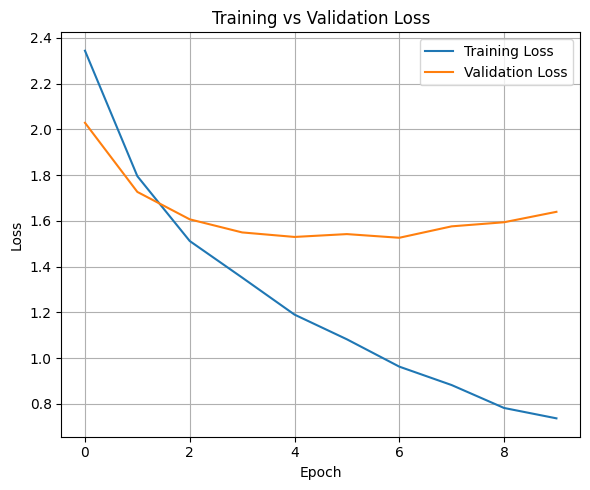

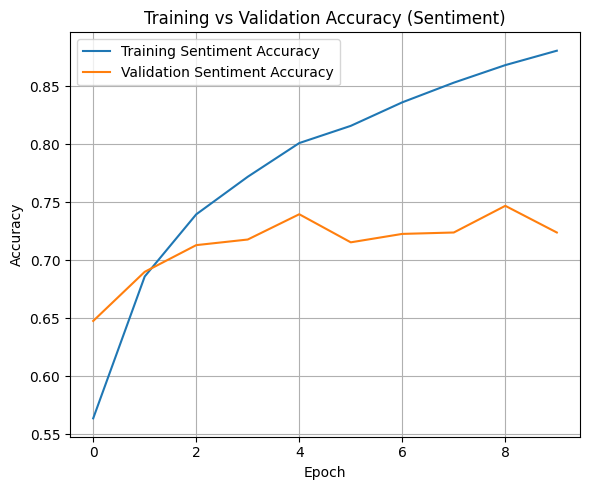

In [10]:
# --- Training vs Validation Loss ---
plt.figure(figsize=(6, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("training_validation_loss.png", dpi=300, bbox_inches="tight")
plt.show()
# --- Training vs Validation Accuracy (Sentiment) ---
plt.figure(figsize=(6, 5))
plt.plot(history.history['sentiment_accuracy'], label='Training Sentiment Accuracy')
plt.plot(history.history['val_sentiment_accuracy'], label='Validation Sentiment Accuracy')
plt.title('Training vs Validation Accuracy (Sentiment)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("training_validation_accuracy.png", dpi=300, bbox_inches="tight")
plt.show()


26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step
=== Sentiment Classification Report ===
              precision    recall  f1-score   support

    negative       0.79      0.74      0.76       344
     neutral       0.70      0.46      0.56       186
    positive       0.67      0.87      0.76       296

    accuracy                           0.72       826
   macro avg       0.72      0.69      0.69       826
weighted avg       0.73      0.72      0.72       826

=== Aspect Classification Report ===
              precision    recall  f1-score   support

  corruption       0.73      0.74      0.73       204
     economy       0.79      0.70      0.74       113
  governance       0.58      0.66      0.62       143
      policy       0.62      0.51      0.56       160
     service       0.76      0.83      0.79       206

    accuracy                           0.70       826
   macro avg       0.70      0.69      0.69       826
weighted avg       0.70      0.70      0.70       826



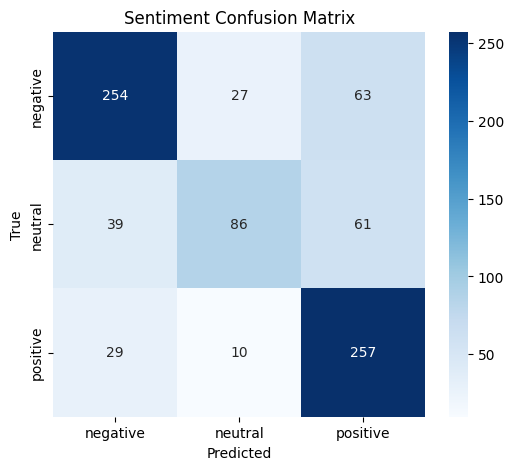

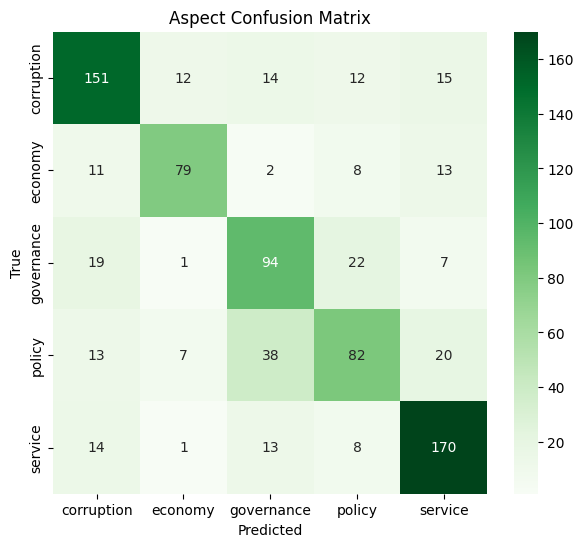

In [11]:
sentiment_probs, aspect_probs = model.predict(X_test)

y_sent_pred = np.argmax(sentiment_probs, axis=1)
y_asp_pred = np.argmax(aspect_probs, axis=1)

y_sent_true = np.argmax(y_sent_test, axis=1)
y_asp_true = np.argmax(y_aspect_test, axis=1)

print("=== Sentiment Classification Report ===")
print(classification_report(y_sent_true, y_sent_pred, target_names=sentiment_encoder.classes_))

print("=== Aspect Classification Report ===")
print(classification_report(y_asp_true, y_asp_pred, target_names=aspect_encoder.classes_))

# Confusion Matrices
cm_sent = confusion_matrix(y_sent_true, y_sent_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_sent, annot=True, fmt="d", cmap="Blues",
            xticklabels=sentiment_encoder.classes_,
            yticklabels=sentiment_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Sentiment Confusion Matrix")
plt.show()

cm_asp = confusion_matrix(y_asp_true, y_asp_pred)
plt.figure(figsize=(7, 6))
sns.heatmap(cm_asp, annot=True, fmt="d", cmap="Greens",
            xticklabels=aspect_encoder.classes_,
            yticklabels=aspect_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Aspect Confusion Matrix")
plt.show()

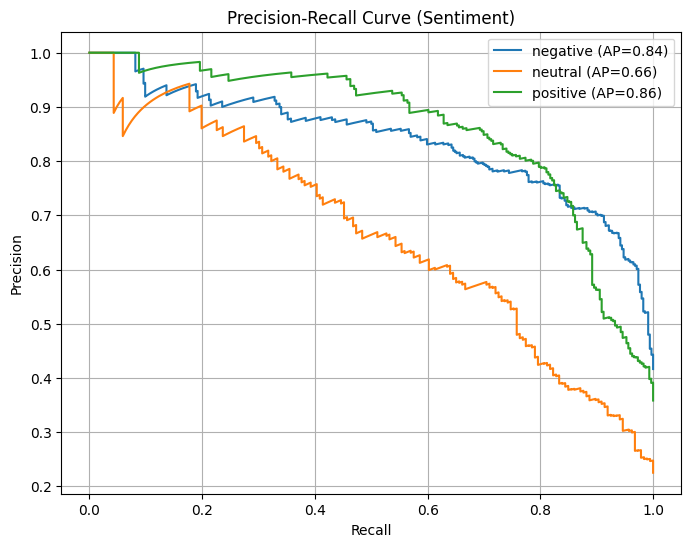

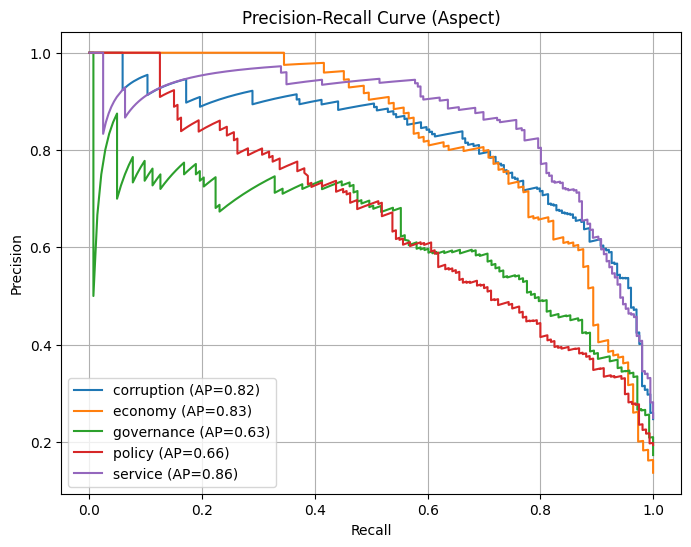

In [12]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# --- Precision-Recall Curves for Sentiment ---
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(sentiment_encoder.classes_):
    y_true_bin = (y_sent_true == i).astype(int)
    y_score = sentiment_probs[:, i]
    precision, recall, _ = precision_recall_curve(y_true_bin, y_score)
    ap = average_precision_score(y_true_bin, y_score)
    plt.plot(recall, precision, label=f"{class_name} (AP={ap:.2f})")

plt.title("Precision-Recall Curve (Sentiment)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.savefig("precision_recall_sentiment.png", dpi=300, bbox_inches="tight")
plt.show()

# --- Precision-Recall Curves for Aspect ---
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(aspect_encoder.classes_):
    y_true_bin = (y_asp_true == i).astype(int)
    y_score = aspect_probs[:, i]
    precision, recall, _ = precision_recall_curve(y_true_bin, y_score)
    ap = average_precision_score(y_true_bin, y_score)
    plt.plot(recall, precision, label=f"{class_name} (AP={ap:.2f})")

plt.title("Precision-Recall Curve (Aspect)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.savefig("precision_recall_aspect.png", dpi=300, bbox_inches="tight")
plt.show()

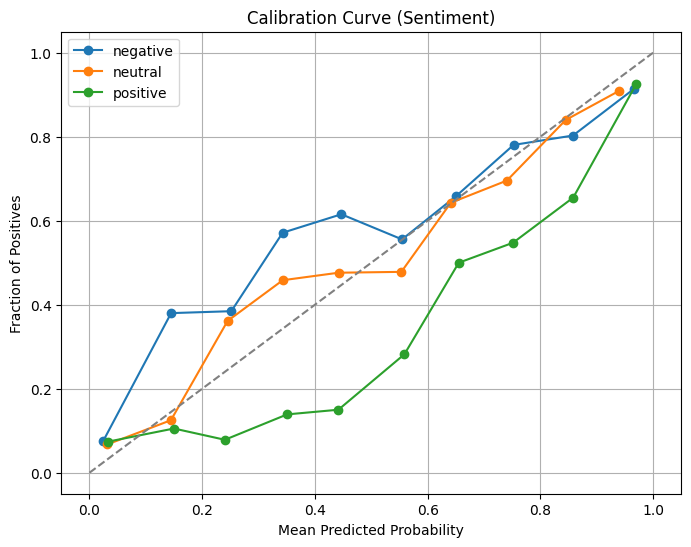

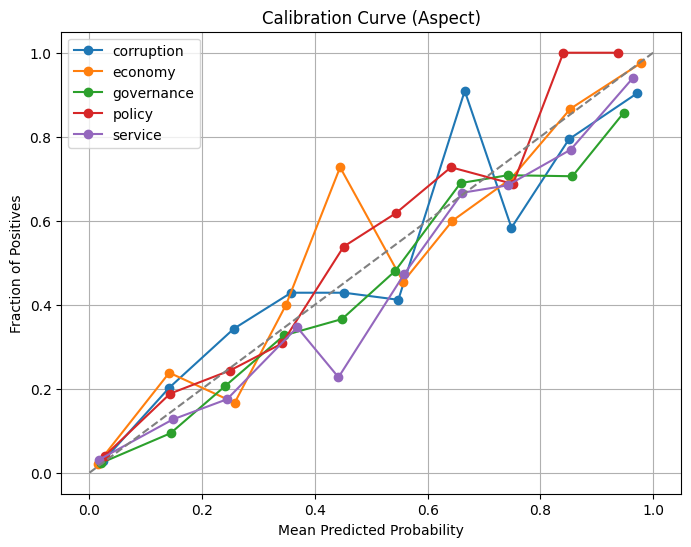

In [13]:
from sklearn.calibration import calibration_curve

# --- Calibration Curve for Sentiment ---
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(sentiment_encoder.classes_):
    y_true_bin = (y_sent_true == i).astype(int)
    y_score = sentiment_probs[:, i]
    prob_true, prob_pred = calibration_curve(y_true_bin, y_score, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=f"{class_name}")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # perfect calibration line
plt.title("Calibration Curve (Sentiment)")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.legend()
plt.grid(True)
plt.show()

# --- Calibration Curve for Aspect ---
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(aspect_encoder.classes_):
    y_true_bin = (y_asp_true == i).astype(int)
    y_score = aspect_probs[:, i]
    prob_true, prob_pred = calibration_curve(y_true_bin, y_score, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=f"{class_name}")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("Calibration Curve (Aspect)")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.legend()
plt.grid(True)
plt.show()

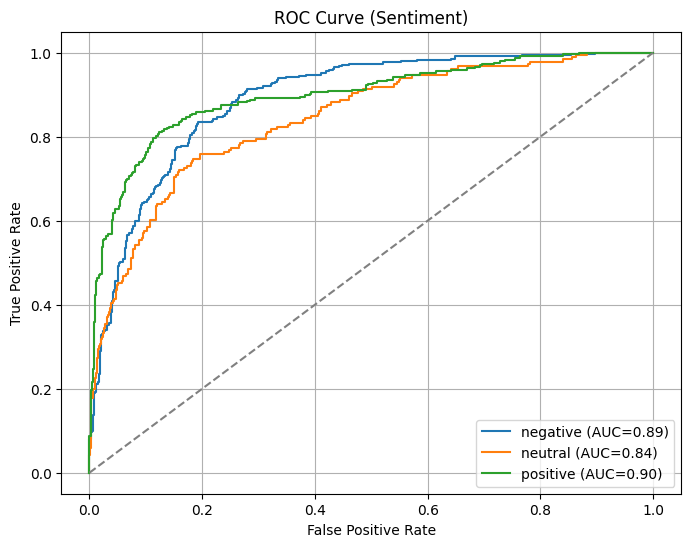

In [14]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# --- ROC Curves for Sentiment ---
# Binarize true labels for multi-class ROC
y_sent_true_bin = label_binarize(y_sent_true, classes=range(len(sentiment_encoder.classes_)))

plt.figure(figsize=(8, 6))
for i, class_name in enumerate(sentiment_encoder.classes_):
    fpr, tpr, _ = roc_curve(y_sent_true_bin[:, i], sentiment_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_name} (AUC={roc_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # diagonal line
plt.title("ROC Curve (Sentiment)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.savefig("roc_curve_sentiment.png", dpi=300, bbox_inches="tight")
plt.show()